# Idealized Case 3: Tracking of a Test Blob in 3D

This tutorial shows the most important steps of tracking with `tobac` using an idealized case:

1. [Input Data](#1.-Input-Data)
2. [Feature Detection](#2.-Feature-Detection)
3. [Tracking / Trajectory Linking](#3.-Trajectory-Linking)
4. [Segmentation](#4.-Segmentation)
5. [Statistical Analysis](#5.-Statistical-Analysis)

## Import Libraries

We start by importing tobac:

In [114]:
import tobac

print("using tobac version", str(tobac.__version__))

# We add testing here to create test dataset (typically not needed in standard applications).
import tobac.testing

using tobac version 1.6.1


We will also need matplotlib in inline-mode for plotting and numpy:

In [115]:
import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np

Tobac works with a Python package called `xarray`, which introduces `DataArrays`. In a nutshell these are `numpy`-arrays with intuitive dimensions, coordinates and meta-data. For a more extensive description have a look at the [xarray Documentation](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.html#xarray.DataArray).

In [116]:
import os
CI = os.environ.get("CI") == "true"

## 1. Input Data

    
There are several utilities implemented in tobac to create simple examples of such arrays. In this tutorial we will use the function `make_simple_sample_data_3D_1blob()` to create a moving test blob in 3D:

In [117]:
test_data = tobac.testing.make_sample_data_3D_1blob(data_type="xarray")
test_data

<xarray.DataArray 'w' (time: 25, z: 50, y: 50, x: 100)> Size: 50MB
[6250000 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 200B 2000-01-01T12:00:00 ... 2000-01-01T...
  * z          (z) float64 400B 0.0 1e+03 2e+03 ... 4.7e+04 4.8e+04 4.9e+04
  * y          (y) float64 400B 0.0 1e+03 2e+03 ... 4.7e+04 4.8e+04 4.9e+04
  * x          (x) float64 800B 0.0 1e+03 2e+03 ... 9.7e+04 9.8e+04 9.9e+04
    latitude   (y, x) float64 40kB ...
    longitude  (y, x) float64 40kB ...
Attributes:
    units:    m s-1

As you can see our generated data describes a field called 'w' with 25 datapoints of time and the unit m/s at 100, 50, 50 of x, y and z. Additionally, the data contains the latitude and longitude coordinates of the field values. To access the values of 'w' in the first timeframe, we can use

In [118]:
test_data.data[0][:3, :3, :3]

array([[[0.13299884, 0.19448215, 0.27323722],
        [0.19448215, 0.28438825, 0.39955058],
        [0.27323722, 0.39955058, 0.56134763]],

       [[0.15298508, 0.22370772, 0.31429762],
        [0.22370772, 0.32712435, 0.45959257],
        [0.31429762, 0.45959257, 0.64570347]],

       [[0.16907466, 0.24723526, 0.34735259],
        [0.24723526, 0.36152832, 0.50792834],
        [0.34735259, 0.50792834, 0.7136127 ]]])

which is then just an array of numbers of the described shape.

To visualize the data, we can plot individual time frames using volume rendering with pyvista:

When wanting to use volume rendering, whe need to import pyvista and set the jupyter_backend to enable interaction in the plot (only for jupyter notebooks).

In [119]:
import pyvista as pv

# Change the jupyter backend to "trame" for an interactive 3d plot
pv.set_jupyter_backend("static")

Now lets define a function for plotting the data which takes our **test_data** and **time_steps**.

Lets first define our camera position and common parameters:

In [120]:
camera_position = [
        (-76500.5898924075427, -115800.2814728167132, 63500.2875750954609),
        (48300.07425870497735, 23000.09685523435806, 14900.89298509023922),
        (0.1647616055738843, 0.19018222800234177, 0.9678245365151585)
    ]

common_bounds_args = dict(
        xtitle='Longitude',
        ytitle='Latitude',
        ztitle='Altitude (m)',
        font_size=10,
        location='outer'
)

Now lets define the timesteps we want to see. 

In [121]:
time_steps = [0, 10, 20]

The function plots the blob at different time steps in one plot. You can add or remove time_steps.

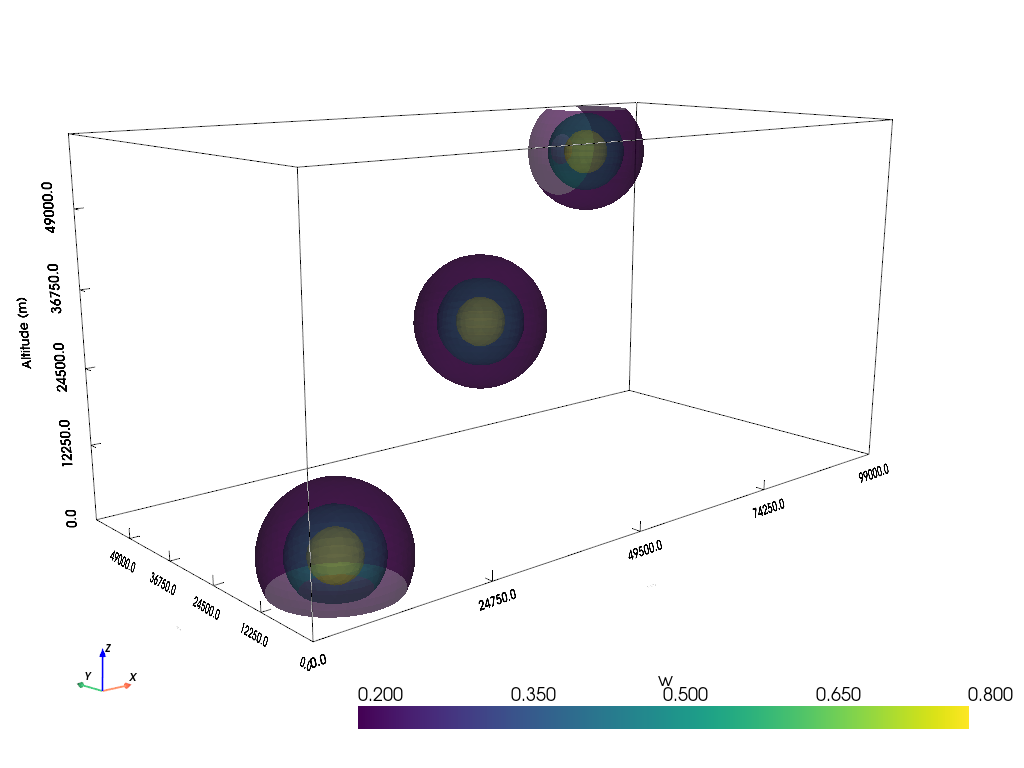

In [122]:
def volume_rendering(test_data, times, pl):
    # Create grid (x, y, z are coordinates)
    x, y, z = np.meshgrid(test_data.x, test_data.y, test_data.z, indexing="ij")
    grid = pv.StructuredGrid(x, y, z)

    # Add the outline of the grid and axes
    pl.add_mesh(grid.outline(), color="black", line_width=1)
    pl.add_axes()
    pl.show_bounds(**common_bounds_args)
    pl.camera_position = camera_position

    for i, time_step in enumerate(times):
        blob = test_data.isel(time=time_step).values
        grid["w"] = blob.ravel()
        normalized_w = (grid["w"] - grid["w"].min()) / (grid["w"].max() - grid["w"].min())
        grid["w"] = normalized_w

        contours = grid.contour(isosurfaces=[0.2, 0.5, 0.8], scalars="w")
        pl.add_mesh(contours, cmap="viridis", opacity=0.7)

    if not CI:
        pl.show(auto_close=False)

pl = pv.Plotter()
volume_rendering(test_data, time_steps, pl)
pl.close()

This tells us that our data is a single moving blob, which is what we are going the analyze with tobac now.

## 2. Feature Detection

The first step of the general working routine of tobac is the identification of features. This essentially means finding the maxima or minima of the data.

To use the according functions of tobac we need to specify:

- the thresholds below/above the features are detected
- the spacing of our data

The spacing of the temporal and spatial dimension can be extracted from the data using a build-in utility:

In [123]:
dxy, dt = tobac.get_spacings(test_data)

To get an idea of which order of magnitude our thresholds should be, we check the maximum of our data:

In [124]:
test_data.max()

<xarray.DataArray 'w' ()> Size: 8B
array(10.)

Since we know that our data will only have one maximum it is reasoable to choose 9 as our threshold, but keep in mind that we could also add multiple values here if our data would be more complex.

In [125]:
threshold = 9

Now we are ready to apply the feature detection algorithm. Notice that this is a minimal input. The function has several other options we will cover in later tutorials.

In [126]:
# %%capture
features = tobac.feature_detection_multithreshold(test_data, dxy, threshold)
# This shows the first five rows
features.head(5)

,frame,idx,vdim,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,z,y,x,latitude,longitude
0,0,1,4.000000,10.000000,10.000000,33,9,1,2000-01-01 12:00:00,2000-01-01 12:00:00,4000.000000,10000.000000,10000.000000,24.100000,150.100000
1,1,1,5.840909,11.613636,13.545455,44,9,2,2000-01-01 12:02:00,2000-01-01 12:02:00,5840.909091,11613.636364,13545.454545,24.135455,150.116136
2,2,1,7.731707,13.390244,17.268293,41,9,3,2000-01-01 12:04:00,2000-01-01 12:04:00,7731.707317,13390.243902,17268.292683,24.172683,150.133902
3,3,1,9.658537,15.121951,20.756098,41,9,4,2000-01-01 12:06:00,2000-01-01 12:06:00,9658.536585,15121.951220,20756.097561,24.207561,150.151220
4,4,1,11.642857,16.761905,24.452381,42,9,5,2000-01-01 12:08:00,2000-01-01 12:08:00,11642.857143,16761.904762,24452.380952,24.244524,150.167619


The ouputs tells us that features were found in 25 **frame**s  (index 0 to 24) of our data. The variable **idx** is 1 for every frame, which means that only 1 feature was found in every time step, as we expected. **vdim**, **hdim_1** and **hdim_2** are the position of this feature with respect to the z, y and x-indices.

We can plot the detected feature positions in the 3D grid.

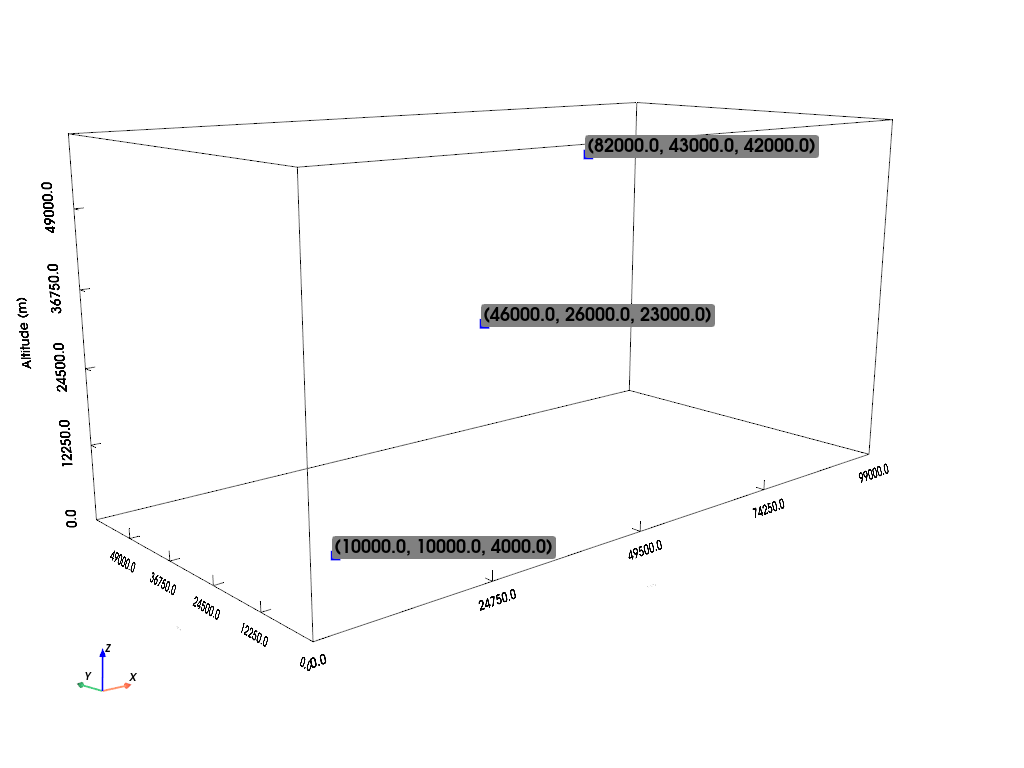

In [127]:
# Create a PyVista Plotter object
pl = pv.Plotter()

# Create grid
x, y, z = np.meshgrid(test_data.x, test_data.y, test_data.z, indexing="ij")
grid = pv.StructuredGrid(x, y, z)

# Add the outline of the grid and axes
pl.add_mesh(grid.outline(), color="black", line_width=1)
pl.add_axes()
pl.show_bounds(**common_bounds_args)
pl.camera_position = camera_position

# Extract 3D coordinates of features
points = np.column_stack(
    [
        test_data.x.values[features["hdim_2"].astype(int)],
        test_data.y.values[features["hdim_1"].astype(int)],
        test_data.z.values[features["vdim"].astype(int)],
    ]
)

# Add grid outline and axes
pl.add_mesh(grid.outline(), color="black", line_width=1)
pl.add_axes()

labels = [f"({x}, {y}, {z})" for x, y, z in points]

# Collect visible points & labels for selected time steps
vis_points = points[time_steps]
vis_labels = [f"({x:.1f}, {y:.1f}, {z:.1f})" for x, y, z in vis_points]

# Add point labels for the selected time steps
pl.add_point_labels(vis_points, vis_labels, point_color="blue", point_size=10)

# Show the plot
if not CI:
    pl.show(auto_close=False)
pl.close()

The function has succesfully detected the maximum of our data in the individual timeframes.

## 3. Trajectory Linking

After we are done finding the features and associated segments for each frame it is necessary for further analysis to keep track of those elements troughout time. Linking is the tool for that. It connects the features of the timesteps which belong together. We are going to use the *linking_trackpy()* function here. The required inputs are the features, the two spacings and a maximum velocity of the features.

In [128]:
trajectories = tobac.linking_trackpy(features, test_data, dt=dt, dxy=dxy, v_max=100)

Frame 24: 1 trajectories present.


Unsurprisingly, one trajectory was found. The returned object is another Dataset:

In [129]:
# This shows the first five rows
trajectories.head(5)

,frame,idx,vdim,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,z,y,x,latitude,longitude,cell,time_cell
0,0,1,4.000000,10.000000,10.000000,33,9,1,2000-01-01 12:00:00,2000-01-01 12:00:00,4000.000000,10000.000000,10000.000000,24.100000,150.100000,1,0 days 00:00:00
1,1,1,5.840909,11.613636,13.545455,44,9,2,2000-01-01 12:02:00,2000-01-01 12:02:00,5840.909091,11613.636364,13545.454545,24.135455,150.116136,1,0 days 00:02:00
2,2,1,7.731707,13.390244,17.268293,41,9,3,2000-01-01 12:04:00,2000-01-01 12:04:00,7731.707317,13390.243902,17268.292683,24.172683,150.133902,1,0 days 00:04:00
3,3,1,9.658537,15.121951,20.756098,41,9,4,2000-01-01 12:06:00,2000-01-01 12:06:00,9658.536585,15121.951220,20756.097561,24.207561,150.151220,1,0 days 00:06:00
4,4,1,11.642857,16.761905,24.452381,42,9,5,2000-01-01 12:08:00,2000-01-01 12:08:00,11642.857143,16761.904762,24452.380952,24.244524,150.167619,1,0 days 00:08:00


The new variable cell now indexes the features in the different time steps. Therefore we can use it to create a mask for our moving feature:

In [130]:
track_mask = trajectories["cell"] == 1.0

This mask can then be used 
- to select the track:

In [131]:
track = trajectories.where(track_mask).dropna()

- and to show the track in our 3D plots: 

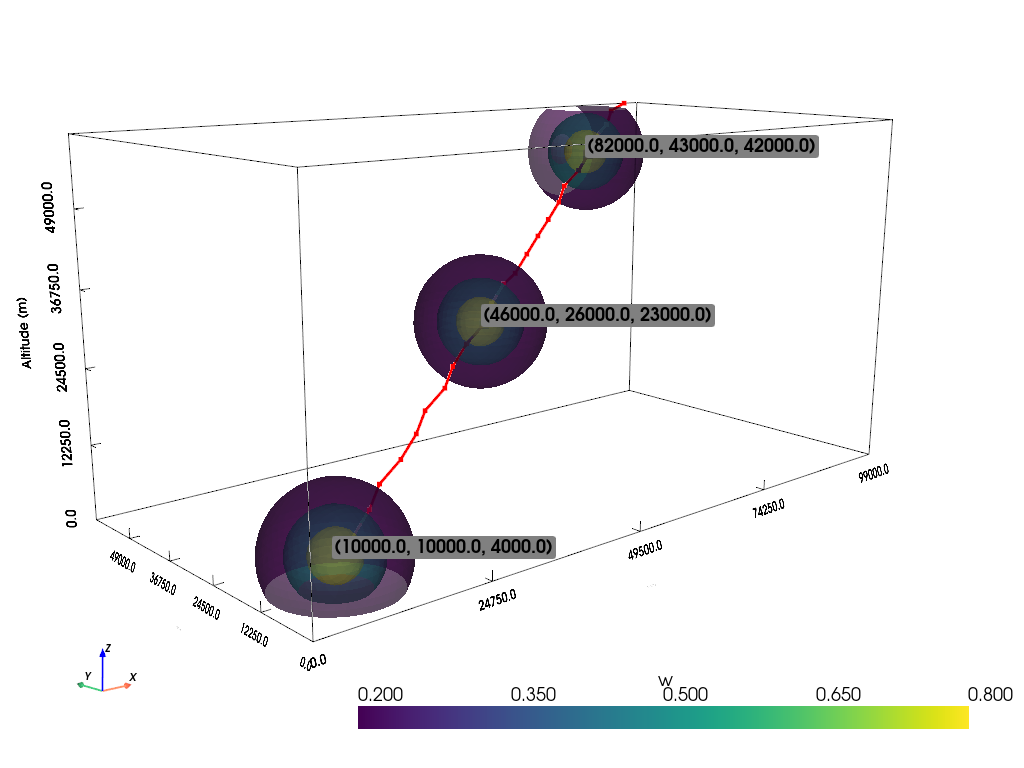

In [132]:
# Create a PyVista Plotter object
pl = pv.Plotter()

# Create grid
x, y, z = np.meshgrid(test_data.x, test_data.y, test_data.z, indexing="ij")
grid = pv.StructuredGrid(x, y, z)

# Add grid outline and axes
pl.add_mesh(grid.outline(), color="black", line_width=1)
pl.add_axes()

# Extract 3D coordinates of features
points = np.column_stack(
    [
        test_data.x.values[features["hdim_2"].astype(int)],
        test_data.y.values[features["hdim_1"].astype(int)],
        test_data.z.values[features["vdim"].astype(int)],
    ]
)

tracks = np.column_stack(
    [
        test_data.x.values[track["hdim_2"].astype(int)],
        test_data.y.values[track["hdim_1"].astype(int)],
        test_data.z.values[track["vdim"].astype(int)],
    ]
)

labels = [f"({x}, {y}, {z})" for x, y, z in points]

# Collect visible points & labels for selected time steps
vis_points = points[time_steps]
vis_labels = [f"({x:.1f}, {y:.1f}, {z:.1f})" for x, y, z in vis_points]

# Add point labels for the selected time steps
pl.add_point_labels(vis_points, vis_labels, point_color="blue", point_size=10)

# Create the connectivity array for lines
lines = []
for i in range(len(tracks) - 1):
    lines.append([2, i, i + 1])

# Flatten the list of lines for the connectivity array
lines = np.array(lines).flatten()

# Create the PolyData object with the line segments
track_poly = pv.PolyData(tracks)
track_poly.lines = lines

# Add tracks to the plot
pl.add_mesh(track_poly, color="red", line_width=3)

volume_rendering(test_data, time_steps, pl)
pl.close()

## 4. Segmentation

After feature detection, segmentation identifies the 3D volumes associated with each detected feature. While we conceptually
present the steps as:

1. Feature detection  
2. Segmentation  
3. Tracking  

the order of steps 2 and 3 is flexible. Since the current segmentation method only relies on the detected features, it can
be performed either before or after tracking.

Two valid workflows exist:

- **Segmentation → Tracking**  
  Tracking uses the segmented objects as input, and resulting trajectories include information such as feature volume
  (`ncells`).

- **Tracking → Segmentation**  
  Segmentation uses only those features that are successfully linked to trajectories, so the resulting mask contains only
  tracked objects.

Both approaches are supported and can be chosen depending on the analysis goal.

In [133]:
segment_labels, segments = tobac.segmentation_3D(features, test_data, dxy, threshold=9)

As the name implies, the first object returned is an array in which the segmented volumes belonging to each feature have the same label value as that feature. The second output is a dataframe of the detected features updated with information about their segmented regions (currently only the number of pixels segmented)

In [134]:
segment_labels

<xarray.DataArray 'segmentation_mask' (time: 25, z: 50, y: 50, x: 100)> Size: 50MB
array([[[[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         ...,
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0]],

        [[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         ...,
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0]],

        [[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         ...,
...
         ...,
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0]],

        [[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         ...,
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0]],

        [[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         ...,
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ..., 25,  0,  0]]]])
Coordinates:
  * time       (time) datetime64[ns] 200B 2000-01-01T12:00:00 ... 2000-01-01T...
  * z          (z) float64 400B 0.0 1e+03 2e+03 ... 4.7e+04 4.8e+04 4.9e+04
  * y          (y) float64 400B 0.0 1e+03 2e+03 ... 4.7e+04 4.8e+04 4.9e+04
  * x          (x) float64 800B 0.0 1e+03 2e+03 ... 9.7e+04 9.8e+04 9.9e+04
    latitude   (y, x) float64 40kB ...
    longitude  (y, x) float64 40kB ...
Attributes:
    threshold:  9

***Exploration of Segmented Data at Varying Thresholds***

Next, we investigate the segmented data using different threshold values. To facilitate this analysis, we visualize the segments across various time steps, displaying the segmentation results at different threshold levels within a single 3D plot. 

In [135]:
thresholds = [3, 6, 9]
segment_labels_0, segments_0 = tobac.segmentation_3D(
    features, test_data, dxy, threshold=thresholds[0]
)
segment_labels_1, segments_1 = tobac.segmentation_3D(
    features, test_data, dxy, threshold=thresholds[1]
)
segment_labels_2, segments_2 = tobac.segmentation_3D(
    features, test_data, dxy, threshold=thresholds[2]
)
segment_label = [segment_labels_0, segment_labels_1, segment_labels_2]
segments = [segments_0, segments_1, segments_2]

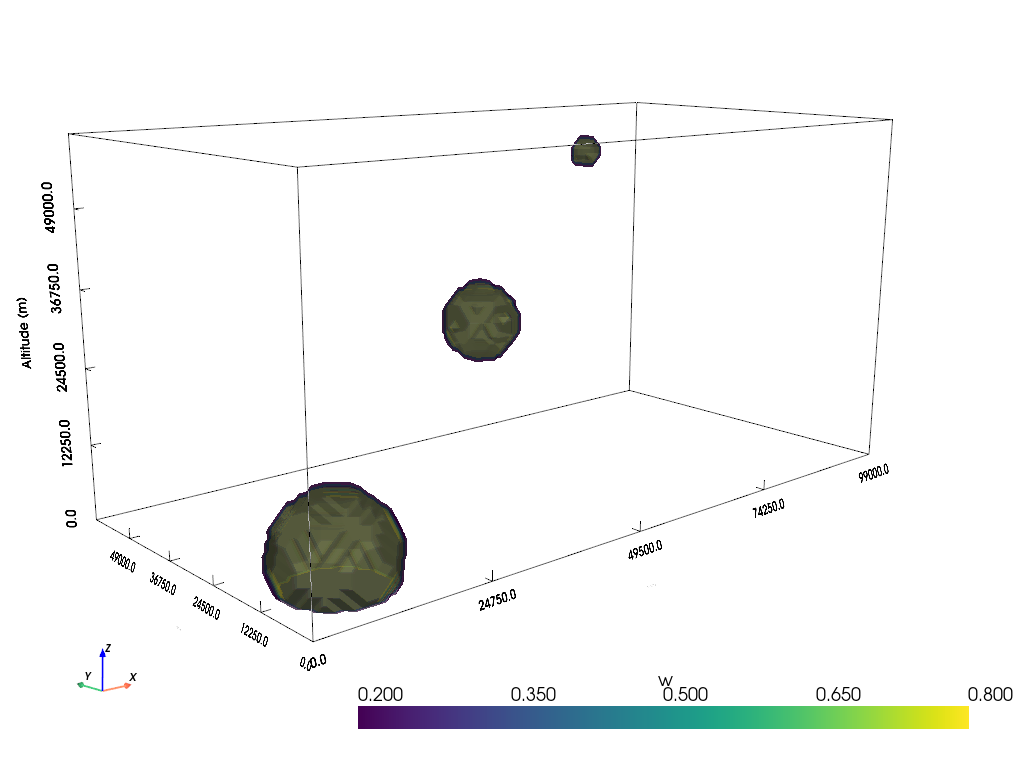

In [136]:
# Create grid for PyVista
x, y, z = np.meshgrid(test_data.x, test_data.y, test_data.z, indexing="ij")
grid = pv.StructuredGrid(x, y, z)
# Create plotter
pl = pv.Plotter()

# Outline the grid for reference  
pl.add_mesh(grid.outline(), color="black", line_width=1)
pl.add_axes()
pl.show_bounds(**common_bounds_args)
pl.camera_position = camera_position

for i, time_step in enumerate(time_steps):
    labels = segment_label[i][time_step].values
    grid["w"] = labels.ravel()
    normalized_w = (grid["w"] - grid["w"].min()) / (grid["w"].max() - grid["w"].min())
    grid["w"] = normalized_w
    # Visualize the segmentation labels
    contours = grid.contour(isosurfaces=[0.2, 0.5, 0.8], scalars="w")
    pl.add_mesh(contours, cmap="viridis", opacity=0.7)

if not CI:
    pl.show(auto_close=False)
pl.close()

That shows that the volume of the resulting segments crucially depends on the defined thresholds.

## 5. Bulk statistics for segmented features

To characterise segmented objects, we can compute simple statistics of an underlying field over each labeled feature. This provides a direct link between the segmentation output and feature-level
properties.

Using `get_statistics_from_mask`, we pass

- the feature dataframe,
- the segmentation mask, and
- one or more fields (e.g. `test_data`),

and receive an updated dataframe with new columns containing the chosen bulk statistics (e.g. mean, total, max) for each
feature.


In [137]:
from tobac.utils.bulk_statistics import get_statistics_from_mask

# Start from the original features dataframe
features_input = features.copy()

# Segmentation mask and underlying 3D field from the previous steps
segmentation_mask = segment_labels
field_3d = test_data

# Define which statistics we want to compute for each feature
statistics = {}
statistics['mean'] = np.mean
statistics['total'] = np.sum
statistics['max'] = np.max

features_with_stats = get_statistics_from_mask(features_input, segmentation_mask, field_3d, statistic=statistics)

features_with_stats.head()

,frame,idx,vdim,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,z,y,x,latitude,longitude,mean,total,max
0,0,1,4.000000,10.000000,10.000000,33,9,1,2000-01-01 12:00:00,2000-01-01 12:00:00,4000.000000,10000.000000,10000.000000,24.100000,150.100000,9.333259,531.995777,10.0
1,1,1,5.840909,11.613636,13.545455,44,9,2,2000-01-01 12:02:00,2000-01-01 12:02:00,5840.909091,11613.636364,13545.454545,24.135455,150.116136,9.400239,470.011963,9.946384
2,2,1,7.731707,13.390244,17.268293,41,9,3,2000-01-01 12:04:00,2000-01-01 12:04:00,7731.707317,13390.243902,17268.292683,24.172683,150.133902,9.387958,478.785843,9.961036
3,3,1,9.658537,15.121951,20.756098,41,9,4,2000-01-01 12:06:00,2000-01-01 12:06:00,9658.536585,15121.951220,20756.097561,24.207561,150.151220,9.391814,469.590716,9.98018
4,4,1,11.642857,16.761905,24.452381,42,9,5,2000-01-01 12:08:00,2000-01-01 12:08:00,11642.857143,16761.904762,24452.380952,24.244524,150.167619,9.415543,451.946046,9.932072


The resulting dataframe `features_with_stats` contains the original feature information plus a set of new columns with the
requested statistics (here: `mean`, `total`, and `max`) of `test_data` over the grid cells belonging to each segmented feature.

This bulk-statistics capability can be easily extended to multiple fields or different statistics, and it provides a flexible
way to characterise the segmented objects.


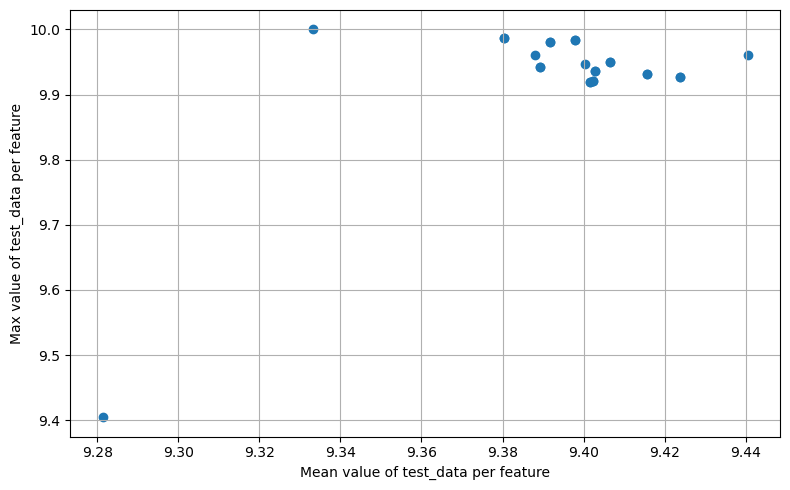

In [138]:
# For a simple overview, keep one row per feature ID
features_summary = (
    features_with_stats
    .sort_values("time")
    .drop_duplicates(subset=["feature"], keep="last")
)

plt.figure(figsize=(8, 5))
plt.scatter(
    features_summary["mean"],   # mean value of the field for each feature
    features_summary["max"],    # corresponding maximum
)

plt.xlabel("Mean value of test_data per feature")
plt.ylabel("Max value of test_data per feature")
plt.grid(True)
plt.tight_layout()
